In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, Input
from PIL import Image, UnidentifiedImageError
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom


In [4]:
train_dir = "C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train"
test_dir = "C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Test"

# Part A: Implementing Convolutional Neural Network from scratch

## Data Understanding, Analysis, Visualization and Cleaning

In [5]:
# List to store corrupted image paths
corrupted_images = []

# Iterate through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image can be opened
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

# Print summary
if not corrupted_images:
    print("No Corrupted Images Found.")

Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\2536529152_33ef3ee078_n.jpg
Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\2908212142_5437fa67ff_n.jpg
Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\33880234094_2541c9c83d_n.jpg
Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\33884228533_91b75ff4d4_n.jpg
Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\34532930772_5cc5fc600d_n.jpg
Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\3475870145_685a19116d.jpg
Removed corrupted image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\4563059851_45a9d21a75.jpg
Removed corrupted image: C:/

In [6]:
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

total_images = sum(class_counts.values())

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)
print(f"{'Total Images':<25}{total_images:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
daisy                                756
dandelion                           1044
rose                                 776
sunflower                            725
tulip                                976
Total Images                        4277


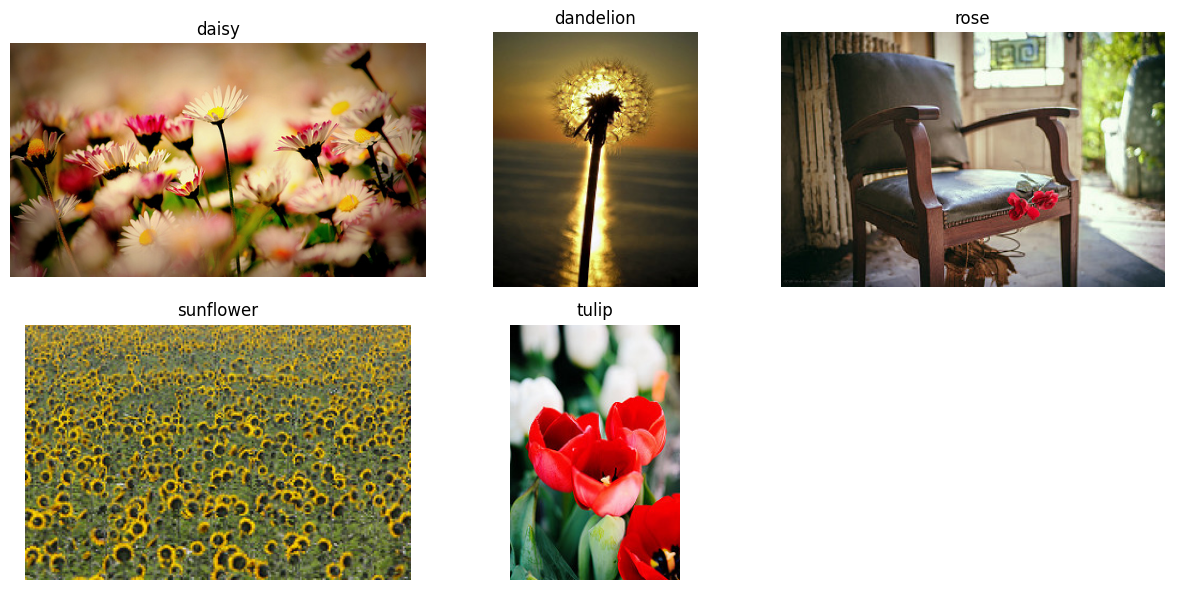

In [7]:
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png','.jpg','.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
cols = (num_classes + 1) // 2
rows = 2
fig, axes = plt.subplots(rows,cols,figsize = (12,6))
for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis("off")
    else:
        ax.axis("off")
plt.tight_layout()
plt.show()

Using image: C:/Users/Admin/OneDrive/Desktop/College/SEM-6/AI_ML/Flower Classification/Train\daisy\100080576_f52e8ee070_n.jpg


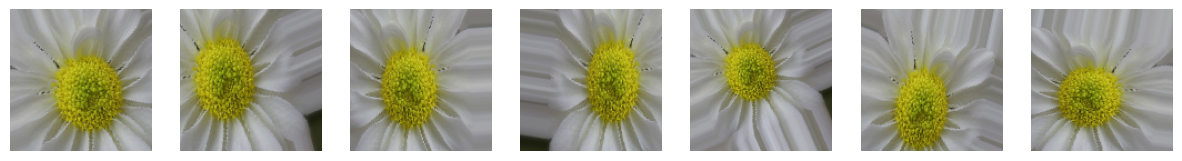

In [8]:
# Pick the first image from the first class folder
first_class_path = os.path.join(train_dir, class_names[0])
image_files = [f for f in os.listdir(first_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    raise ValueError(f"No image files found in {first_class_path}")
    
sample_img_path = os.path.join(first_class_path, image_files[0])
print(f"Using image: {sample_img_path}")

# Load and preprocess image
img = image.load_img(sample_img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)

# Display augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    batch = next(aug_iter)
    ax[i].imshow(batch[0].astype('uint8'))
    ax[i].axis('off')

plt.show()

## Design, Train, and Evaluate a Baseline Model

In [9]:
# Define image size and batch size
img_height = 128
img_width = 128
batch_size = 16
validation_split = 0.2 

# Normalize pixel values to [0, 1]
rescale = tf.keras.layers.Rescaling(1./255)

# Data Augmentation block
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# Add data augmentation to training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
).map(lambda x, y: (rescale(data_augmentation(x)), y))  # <-- Augmented + Normalized

# Validation dataset (only rescaling)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
).map(lambda x, y: (rescale(x), y))


Found 4277 files belonging to 5 classes.
Using 3422 files for training.
Found 4277 files belonging to 5 classes.
Using 855 files for validation.


In [10]:
model = Sequential([
    # Layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),

    # Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Layer 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    # Output Layer
    Dense(4, activation='softmax') # Since there are 4 classes in total
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,557,444 (25.01 MB)

 Trainable params: 6,557,444 (25.01 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 3423 images belonging to 5 classes.
Found 854 images belonging to 5 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i, ax in enumerate(axes.flat):
    img_path = random.choice(selected_images)
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    ax.imshow(load_img(img_path))
    ax.set_title(f"Predicted: {predicted_class}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Design, Train , and Evaluate Deeper Architecture with Regularization Layer

In [ ]:
from tensorflow.keras.regularizers import l2

deep_model = Sequential([
    # Conv Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # FC Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    # Output Layer
    Dense(len(class_names), activation='softmax')
])

deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Model Summary
deep_model.summary()

In [ ]:
from tensorflow.keras.optimizers import SGD

deep_model_sgd = Sequential([
    # Conv Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # FC Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    # Output Layer
    Dense(len(class_names), activation='softmax')
])

deep_model_sgd.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Model Summary
deep_model_sgd.summary()

In [ ]:
deep_history = deep_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

In [ ]:
history_sgd = deep_model_sgd.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

In [ ]:
# Plotting loss curves of both models
plt.figure(figsize=(12,6))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Baseline Train')
plt.plot(history.history['val_loss'], label='Baseline Val')
plt.plot(deep_history.history['loss'], label='Deeper Train (with adam)')
plt.plot(deep_history.history['val_loss'], label='Deeper Val (with adam)')
plt.plot(history_sgd.history['loss'], label='Deeper Train (with sgd)')
plt.plot(history_sgd.history['val_loss'], label='Deeper Val (with sgd)')
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Baseline Train')
plt.plot(history.history['val_accuracy'], label='Baseline Val')
plt.plot(deep_history.history['accuracy'], label='Deeper Train (with adam)')
plt.plot(deep_history.history['val_accuracy'], label='Deeper Val (with adam)')
plt.plot(history_sgd.history['accuracy'], label='Deeper Train (with sgd)')
plt.plot(history_sgd.history['val_accuracy'], label='Deeper Val (with sgd)')
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
val_generator.reset()
Y_pred_deep = deep_model.predict(val_generator, steps=len(val_generator))
y_pred_deep = np.argmax(Y_pred_deep, axis=1)
y_true = val_generator.classes

print("Deeper Model Evaluation:\n")
print(classification_report(y_true, y_pred_deep, target_names=class_labels))

# Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False  # Freezing the convolutional layers to retain the learned features

x = base_model.output
x = Flatten()(x)  # Flatten the output of the convolutional layers
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(5, activation='softmax')(x)  # Output layer (adjust number of classes as needed)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up directories
train_dir = 'Train'  # Directory for training data
test_dir = 'Test'    # Directory for test data

# Image size expected by VGG16 (224x224)
img_size = (224, 224)
batch_size = 32

# Data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Resize images to 224x224 for VGG16
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training',         # Use subset for training
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Resize images to 224x224 for VGG16
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='validation',       # Use subset for validation
    shuffle=True
)

In [ ]:
# Handling Test Data (Manually loading)
test_images = []
test_labels = []
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']  # Adjust this to match your dataset

# Manually load and preprocess test images
for img_name in os.listdir(test_dir):
    if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Adjust based on your file types
        img_path = os.path.join(test_dir, img_name)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0  # Normalize image
        test_images.append(img_array)
        
        # Predict the label using the model
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        test_labels.append(predicted_class_index)

In [ ]:
# Convert to numpy arrays and one-hot encode labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(class_names))

# Load VGG16 without top layers (pre-trained model)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model (convolutional layers)

# Add custom classification head
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)  # Add a fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting
output = layers.Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer for multi-class classification

In [ ]:
# Create the model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model (only the new layers will be trained)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model (only the custom head layers will be trained)
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Fine-Tuning: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True  # Unfreeze the last 4 layers

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again with the base and custom layers trained
history_finetune = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on manually loaded test set
predictions = model.predict(test_images)

In [ ]:
# Calculate accuracy
predicted_class_indices = np.argmax(predictions, axis=1)
correct_predictions = np.sum(predicted_class_indices == np.argmax(test_labels, axis=1))
total_predictions = len(test_labels)
accuracy = correct_predictions / total_predictions
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Plot the accuracy for training and validation
plt.plot(history.history['accuracy'], label='train accuracy (feature extraction)')
plt.plot(history.history['val_accuracy'], label='val accuracy (feature extraction)')
plt.plot(history_finetune.history['accuracy'], label='train accuracy (fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy (fine-tuning)')
plt.title("Transfer Learning: VGG16 - Feature Extraction and Fine-Tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels for test data
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Accuracy (already printed earlier)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix - Fine-Tuned Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
img_path = 'Train/rose/102501987_3cdb8e5394_n.jpg'  # Replace with actual path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0 

# Adding batch dimension
img_array = np.expand_dims(img_array, axis=0)  

# Make prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]

# Output result
print(f"Predicted class: {predicted_class_name}")